# K-Means Movie Recommendation Engine

## AWS Services Used

### Athena
Used to prepare datasets using SQL <br/>
https://aws.amazon.com/athena <br/>

### SageMaker
Used to model the dataset and provide predictions <br/>
https://aws.amazon.com/sagemaker/ <br/>

### S3
Used to store dataset files <br/>
https://aws.amazon.com/s3/ <br/>

## Data Sources

### IMDB

https://www.imdb.com/interfaces/ <br/>

**title.akas** <br/>
* titleId (string) - a tconst, an alphanumeric unique identifier of the title
* ordering (integer) – a number to uniquely identify rows for a given titleId
* title (string) – the localized title
* region (string) - the region for this version of the title
* language (string) - the language of the title
* types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
* attributes (array) - Additional terms to describe this alternative title, not enumerated
* isOriginalTitle (boolean) – 0: not original title; 1: original title
<br/>

**title.basics** <br/>
* tconst (string) - alphanumeric unique identifier of the title
* titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
* primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
* originalTitle (string) - original title, in the original language
* isAdult (boolean) - 0: non-adult title; 1: adult title
* startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
* endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
* runtimeMinutes – primary runtime of the title, in minutes
* genres (string array) – includes up to three genres associated with the title
<br/>

**title.ratings** <br/>
* tconst (string) - alphanumeric unique identifier of the title
* averageRating – weighted average of all the individual user ratings
* numVotes - number of votes the title has received
<br/>

---

### Import Dependencies

In [1]:
import boto3
import io
import numpy as np
import pandas as pd
import sagemaker
import seaborn

from sagemaker import KMeans
from sklearn.preprocessing import MinMaxScaler

## Download Athena Prepared Data from S3 into Memory
Note: the entire dataset needs to fit into memory

#### Data Limitation Reasonings
I chose to limit the datasets in the following ways because I was trying to create a recommendation engine that appealed to me.
* `tbasics.startyear <= year(now())` to eliminate movies that haven't been released yet
* `tbasics.titleType = 'movie'` to eliminate entries that are not movies like TV shows
* `tbasics.isadult = 0` to eliminate adult content and keep the experiment family friendly
* `takas.language = 'en'` to eliminate movies that are not in English non-English movies
* `takas.region = 'US'` to eliminate movies that did not originate in the United States
<br/>

#### SQL Used to Find Top 10 Genres
```SQL
select
     x.value, count(*) cnt
from title_basics tbasics
join title_akas takas on tbasics.tconst = takas.titleid
left join title_ratings tratings on tbasics.tconst = tratings.tconst
cross join unnest(split(tbasics.genres, ',')) as x(value)
where tbasics.startyear <= year(now()) 
and tbasics.titleType = 'movie' 
and tbasics.isadult = 0
and takas.language = 'en'
and takas.region = 'US'
group by 1
order by 2 desc
limit 10;
```

#### SQL Used to Shape Data
```SQL
select 
	res.*,
	contains(res.genres, 'Action') isaction,
	contains(res.genres, 'Adventure') isadventure,
	contains(res.genres, 'Comedy') iscomedy,
	contains(res.genres, 'Crime') iscrime,
	contains(res.genres, 'Documentary') isdocumentary,
	contains(res.genres, 'Drama') isdrama,
	contains(res.genres, 'Horror') ishorror,
	contains(res.genres, 'Mystery') ismystery,
	contains(res.genres, 'Romance') isromance,
	contains(res.genres, 'Thriller') isthriller
from (
select distinct 
	tbasics.tconst id,
	tbasics.primarytitle title,
	tbasics.startyear year,
	split(tbasics.genres, ',') genres,
	tratings.averagerating rating,
	tratings.numvotes votes
from title_basics tbasics
join title_akas takas on tbasics.tconst = takas.titleid
join title_ratings tratings on tbasics.tconst = tratings.tconst
where tbasics.startyear <= year(now()) 
and tbasics.titleType = 'movie' 
and tbasics.isadult = 0
and takas.language = 'en'
and takas.region = 'US'
) res;
```

#### SQL Used to Count Records in Data (804 Records)
```SQL
select count(*) from (
select distinct 
	tbasics.tconst id,
	tbasics.primarytitle title,
	tbasics.startyear year,
	split(tbasics.genres, ',') genres,
	tratings.averagerating rating,
	tratings.numvotes votes
from title_basics tbasics
join title_akas takas on tbasics.tconst = takas.titleid
join title_ratings tratings on tbasics.tconst = tratings.tconst
where tbasics.startyear <= year(now()) 
and tbasics.titleType = 'movie' 
and tbasics.isadult = 0
and takas.language = 'en'
and takas.region = 'US'
) cnt; 
```

In [2]:
s3_client = boto3.client('s3')
s3_bucket = "wheeler-cloud-guru-challenge-1020"
s3_object = "athena-results/imdb.csv"

imdb_data = s3_client.get_object(Bucket=s3_bucket, Key=s3_object)
imdb_body = imdb_data["Body"].read()
imdb_df = pd.read_csv(io.BytesIO(imdb_body), header=0, delimiter=",", low_memory=False)
imdb_df

,id,title,year,genres,rating,votes,isaction,isadventure,iscomedy,iscrime,isdocumentary,isdrama,ishorror,ismystery,isromance,isthriller
0,tt2073661,Dawn Patrol,2014,"[Drama, Thriller]",4.7,652,False,False,False,False,False,True,False,False,False,True
1,tt2402085,Jimi: All Is by My Side,2013,"[Biography, Drama, Music]",5.7,6274,False,False,False,False,False,True,False,False,False,False
2,tt2527338,Star Wars: Episode IX - The Rise of Skywalker,2019,"[Action, Adventure, Fantasy]",6.6,354287,True,True,False,False,False,False,False,False,False,False
3,tt2554714,Haunting of the Innocent,2014,"[Horror, Thriller]",2.3,393,False,False,False,False,False,False,True,False,False,True
4,tt8737614,Majiji,2019,"[Drama, Romance]",7.2,2779,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,tt1307002,Redemption,2009,"[Action, Crime, Drama]",3.5,510,True,False,False,True,False,True,False,False,False,False
800,tt2564156,In God We Trust,2013,[Documentary],7.6,26,False,False,False,False,True,False,False,False,False,False
801,tt2837574,The Old Man & the Gun,2018,"[Biography, Comedy, Crime]",6.7,39386,False,False,True,True,False,False,False,False,False,False
802,tt3422314,The First Line,2014,[Drama],5.0,244,False,False,False,False,False,True,False,False,False,False


In [3]:
year_df = imdb_df.groupby('year')['id'].nunique()
year_df 

year
1915      1
1917      1
1919      1
1927      1
1930      1
       ... 
2016     39
2017     48
2018     72
2019    144
2020     36
Name: id, Length: 76, dtype: int64

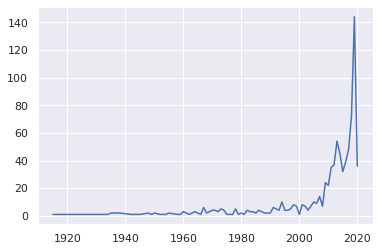

In [4]:
seaborn.set(style='darkgrid')
seaborn.lineplot(data=year_df)

In [5]:
imdb_df['rating'] = imdb_df['rating'].apply(lambda x: int(round(x)))
rating_df = imdb_df.groupby('rating')['id'].nunique()
rating_df

rating
2     11
3     32
4     84
5    121
6    238
7    195
8    107
9     16
Name: id, dtype: int64

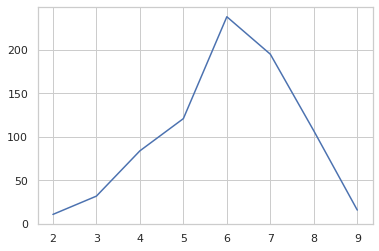

In [6]:
seaborn.set(style='whitegrid')
seaborn.lineplot(data=rating_df)

In [7]:
result_df = imdb_df[['id', 'genres', 'rating', 'title', 'votes', 'year']]
result_df

,id,genres,rating,title,votes,year
0,tt2073661,"[Drama, Thriller]",5,Dawn Patrol,652,2014
1,tt2402085,"[Biography, Drama, Music]",6,Jimi: All Is by My Side,6274,2013
2,tt2527338,"[Action, Adventure, Fantasy]",7,Star Wars: Episode IX - The Rise of Skywalker,354287,2019
3,tt2554714,"[Horror, Thriller]",2,Haunting of the Innocent,393,2014
4,tt8737614,"[Drama, Romance]",7,Majiji,2779,2019
...,...,...,...,...,...,...
799,tt1307002,"[Action, Crime, Drama]",4,Redemption,510,2009
800,tt2564156,[Documentary],8,In God We Trust,26,2013
801,tt2837574,"[Biography, Comedy, Crime]",7,The Old Man & the Gun,39386,2018
802,tt3422314,[Drama],5,The First Line,244,2014


In [8]:
genre_map = {
    "Action": 1,
    "Adventure": 2,
    "Animation": 3,
    "Biography": 4,
    "Comedy": 5,
    "Crime": 6,
    "Documentary": 7,
    "Drama": 8,
    "Family": 9,
    "Fantasy": 10,
    "Film-Noir": 11,
    "History": 12,
    "Horror": 13,
    "Music": 14,
    "Musical": 15,
    "Mystery": 16,
    "News": 17,
    "Romance": 18,
    "Sci-Fi": 19,
    "Sport": 20,
    "Thriller": 21,
    "War": 22,
    "Western": 23
}

def map_genre_to_numeric(genres):
    
    genres_array = genres.replace('[', '').replace(']', '').split(', ')
    return ''.join([str(genre_map[g]) for g in genres_array])


def map_rating_to_numeric(rating, votes):
    
    result = 0
    if votes is None:
        result = 0
    elif votes < 10:
        result = rating * 0.1
    elif votes < 100:
        result = rating * 0.3
    elif votes < 500:
        result = rating * 0.5
    elif votes < 1000:
        result = rating * 0.7
    elif votes >= 1000: 
        result = rating
    else:
        print(f"Unexpected # of Votes: {votes}")
        
    return result


def map_tilte_to_numeric(title):
    return ''.join([str(ord(c)) for c in title[:9]])

In [9]:
train_columns = ['genres', 'rating', 'title', 'votes', 'year']
train_columns.extend([c for c in imdb_df.columns if c.startswith("is")])

train_df = imdb_df[train_columns]
train_df

,genres,rating,title,votes,year,isaction,isadventure,iscomedy,iscrime,isdocumentary,isdrama,ishorror,ismystery,isromance,isthriller
0,"[Drama, Thriller]",5,Dawn Patrol,652,2014,False,False,False,False,False,True,False,False,False,True
1,"[Biography, Drama, Music]",6,Jimi: All Is by My Side,6274,2013,False,False,False,False,False,True,False,False,False,False
2,"[Action, Adventure, Fantasy]",7,Star Wars: Episode IX - The Rise of Skywalker,354287,2019,True,True,False,False,False,False,False,False,False,False
3,"[Horror, Thriller]",2,Haunting of the Innocent,393,2014,False,False,False,False,False,False,True,False,False,True
4,"[Drama, Romance]",7,Majiji,2779,2019,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,"[Action, Crime, Drama]",4,Redemption,510,2009,True,False,False,True,False,True,False,False,False,False
800,[Documentary],8,In God We Trust,26,2013,False,False,False,False,True,False,False,False,False,False
801,"[Biography, Comedy, Crime]",7,The Old Man & the Gun,39386,2018,False,False,True,True,False,False,False,False,False,False
802,[Drama],5,The First Line,244,2014,False,False,False,False,False,True,False,False,False,False


In [10]:
print(f"Before [Genres]:\n{train_df['genres'].head(5)}")
train_df['genres'] = train_df['genres'].map(lambda g: map_genre_to_numeric(g))

print()
print(f"After  [Genres]:\n{train_df['genres'].head(5)}")

Before [Genres]:
0               [Drama, Thriller]
1       [Biography, Drama, Music]
2    [Action, Adventure, Fantasy]
3              [Horror, Thriller]
4                [Drama, Romance]
Name: genres, dtype: object

After  [Genres]:
0     821
1    4814
2    1210
3    1321
4     818
Name: genres, dtype: object


In [11]:
rating_df = train_df[['rating', 'votes']]

print(f"Before [Rating]:\n{rating_df.head(5)}")
train_df['rating'] = rating_df.apply(lambda r: map_rating_to_numeric(r['rating'], r['votes']), axis=1)
del train_df['votes']
      
print()
print(f"After  [Rating]:\n{train_df['rating'].head(5)}")

Before [Rating]:
   rating   votes
0       5     652
1       6    6274
2       7  354287
3       2     393
4       7    2779

After  [Rating]:
0    3.5
1    6.0
2    7.0
3    1.0
4    7.0
Name: rating, dtype: float64


In [12]:
print(f"Before [Title]:\n{train_df['title'].head(5)}")
train_df['title'] = train_df['title'].map(lambda t: map_tilte_to_numeric(t))

print()
print(f"After  [Title]:\n{train_df['title'].head(5)}")

Before [Title]:
0                                      Dawn Patrol
1                          Jimi: All Is by My Side
2    Star Wars: Episode IX - The Rise of Skywalker
3                         Haunting of the Innocent
4                                           Majiji
Name: title, dtype: object

After  [Title]:
0      6897119110328097116114
1     74105109105583265108108
2      8311697114328797114115
3    729711711011610511010332
4            7797106105106105
Name: title, dtype: object


In [13]:
train_df = train_df.astype('float32')
train_df

,genres,rating,title,year,isaction,isadventure,iscomedy,iscrime,isdocumentary,isdrama,ishorror,ismystery,isromance,isthriller
0,821.0,3.5,6.897119e+21,2014.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4814.0,6.0,7.410511e+22,2013.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1210.0,7.0,8.311697e+21,2019.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1321.0,1.0,7.297117e+23,2014.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,818.0,7.0,7.797106e+15,2019.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,168.0,2.8,8.210110e+25,2009.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
800,7.0,2.4,7.311033e+21,2013.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
801,456.0,7.0,8.410410e+21,2018.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
802,8.0,2.5,8.410410e+23,2014.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
scaler = MinMaxScaler()
scaler_columns = ['genres', 'rating', 'title', 'year']
train_df[scaler_columns] = pd.DataFrame(scaler.fit_transform(train_df[scaler_columns]))
train_df

,genres,rating,title,year,isaction,isadventure,iscomedy,iscrime,isdocumentary,isdrama,ishorror,ismystery,isromance,isthriller
0,0.005064,0.375000,8.103761e-05,0.942858,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.029725,0.659091,8.706970e-04,0.933332,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.007467,0.772727,9.765817e-05,0.990477,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008152,0.090909,8.573737e-03,0.942858,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.005046,0.772727,9.161199e-11,0.990477,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.001031,0.295455,9.646457e-01,0.895237,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
800,0.000037,0.250000,8.590088e-05,0.933332,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
801,0.002810,0.772727,9.881800e-05,0.980951,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
802,0.000043,0.261364,9.881800e-03,0.942858,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
sage_session = sagemaker.Session()
sage_outputs = f"s3://{sage_session.default_bucket()}/imdb/"

kmeans = KMeans(role=sagemaker.get_execution_role(),
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path=sage_outputs,              
                k=9)

In [17]:
%%time
train_data = train_df.values
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-29 04:38:00 Starting - Starting the training job...
2020-11-29 04:38:02 Starting - Launching requested ML instances.........
2020-11-29 04:39:45 Starting - Preparing the instances for training......
2020-11-29 04:40:54 Downloading - Downloading input data...
2020-11-29 04:41:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/29/2020 04:41:29 INFO 140387511322432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_

In [18]:
%%time
model = kmeans.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 336 ms, sys: 16.1 ms, total: 352 ms
Wall time: 9min 32s


In [19]:
predictions = model.predict(train_data)
print(f"predictions[0]:\n{predictions[0]}")

predictions[0]:
label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 8.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.6725698113441467
    }
  }
}



In [20]:
sagemaker.Session().delete_endpoint(model.endpoint_name)

In [21]:
result_df['cluster'] = np.nan
result_df['distance'] = np.nan

for i, p in enumerate(predictions):
    result_df.at[i, 'cluster'] = p.label['closest_cluster'].float32_tensor.values[0]
    result_df.at[i, 'distance'] = p.label['distance_to_cluster'].float32_tensor.values[0]
    
result_df

,id,genres,rating,title,votes,year,cluster,distance
0,tt2073661,"[Drama, Thriller]",5,Dawn Patrol,652,2014,8.0,0.672570
1,tt2402085,"[Biography, Drama, Music]",6,Jimi: All Is by My Side,6274,2013,1.0,0.272993
2,tt2527338,"[Action, Adventure, Fantasy]",7,Star Wars: Episode IX - The Rise of Skywalker,354287,2019,2.0,0.375275
3,tt2554714,"[Horror, Thriller]",2,Haunting of the Innocent,393,2014,4.0,0.602473
4,tt8737614,"[Drama, Romance]",7,Majiji,2779,2019,6.0,0.489595
...,...,...,...,...,...,...,...,...
799,tt1307002,"[Action, Crime, Drama]",4,Redemption,510,2009,7.0,1.174846
800,tt2564156,[Documentary],8,In God We Trust,26,2013,5.0,0.193882
801,tt2837574,"[Biography, Comedy, Crime]",7,The Old Man & the Gun,39386,2018,3.0,1.038135
802,tt3422314,[Drama],5,The First Line,244,2014,1.0,0.325176


In [22]:
result_df.to_csv('imdb.csv', encoding='utf-8', index=False)

In [23]:
! aws s3 cp "imdb.csv" "s3://wheeler-cloud-guru-challenge-1020/sagemaker-results/"

upload: ./imdb.csv to s3://wheeler-cloud-guru-challenge-1020/sagemaker-results/imdb.csv
